# 04 - Train Model

In [73]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Disable TensorFlow GPU warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set TensorFlow logging to only show errors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# notebook settings
pd.set_option('display.max_columns', None)

## Step 1: Preprocessing and Preparing Data
### 1.1 Load the Dataset
Start by loading and inspecting your dataset.

In [74]:
data = pd.read_csv(
    os.path.join('..','data','processed','all_concat_football_data.csv')
    )

# Convert to datetime explicitly with format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', errors='coerce')

print(data.shape)

data.head()

(7397, 26)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
0,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,M Riley,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0,2.30,3.25,3.00,2005
1,2005-08-13,Everton,Man United,0.0,2.0,A,0.0,1.0,A,G Poll,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0,5.00,3.40,1.72,2005
2,2005-08-13,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,R Styles,15.0,7.0,7.0,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0,2.37,3.25,2.87,2005
3,2005-08-13,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,C Foy,15.0,13.0,8.0,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0,1.72,3.40,5.00,2005
4,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,M Halsey,4.0,16.0,2.0,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0,2.87,3.20,2.40,2005


### 1.2 Define the Time Window
Decide the number of past matches to consider (n). For example, use the last 5 matches for both teams.

In [75]:
time_window = 5  # Number of previous matches to consider

### 1.3 Create Sequential Features
For each match, create a sliding window of the past n matches for both the home and away teams. Include key features like goals, shots, corners, etc.

In [76]:
def create_sequences(data, team_col, feature_cols, time_window):
    """
    Create sequences of past matches for a given team.
    """
    sequences = []
    for team in data[team_col].unique():
        team_data = data[data[team_col] == team].sort_values(by='Date')
        team_features = team_data[feature_cols].values
        
        # Create rolling window of past matches
        for i in range(len(team_features) - time_window):
            sequences.append(team_features[i:i + time_window])
    return np.array(sequences)

### 1.4 Combine Home and Away Features
Generate sequences for both HomeTeam and AwayTeam and concatenate them.

In [77]:
data.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'Season'],
      dtype='object')

In [78]:
# Features to include in sequences
feature_cols = ['FTHG', 'FTAG','HTHG','HTAG','HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR','B365H','B365D','B365A']

# Generate sequences
home_sequences = create_sequences(data, 'HomeTeam', feature_cols, time_window)
away_sequences = create_sequences(data, 'AwayTeam', feature_cols, time_window)

# Concatenate home and away sequences
X = np.concatenate([home_sequences, away_sequences], axis=2)

# Target variable
y = data['FTR']  # Convert to numerical labels (H=0, D=1, A=2)

### 1.5 Normalize Features
Scale all features to a similar range (e.g., 0 to 1) using a scaler:

In [79]:
# Normalize features
scaler = StandardScaler()

# Reshape X to 2D for scaling: (num_samples * time_steps, num_features)
X_reshaped = X.reshape(-1, X.shape[-1])  # Flatten the time dimension
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape X back to its original shape: (num_samples, time_steps, num_features)
X = X_scaled.reshape(X.shape)

# Encode target variable (e.g., FTR: 'H', 'D', 'A')
le = LabelEncoder()
y = le.fit_transform(y)  # Converts to integers: H=0, D=1, A=2
print("Classes encoded:", le.classes_)  # Check mappings

Classes encoded: ['A' 'D' 'H']


Why These Steps Are Necessary
1. Scaling Input Features:

- Neural networks perform better when input features are normalized, especially for gradient-based optimizers like Adam.
- Without scaling, features with large magnitudes (e.g., attendance or goals) can dominate the model's learning process.

2. Encoding Targets:

- Many machine learning models and neural networks require numeric targets.
- Encoding FTR as integers allows the use of sparse categorical cross-entropy for classification.

### 1.6 Split the Data
Split into training, validation, and testing sets while avoiding temporal leakage.

In [80]:
print(f"Shape of X: {X.shape}")  # Should be 3D
print(f"Shape of y: {y.shape}")  # Should be 1D or 2D

Shape of X: (7177, 5, 34)
Shape of y: (7397,)


In [81]:
num_samples = X.shape[0]  # 7,169
y = y[:num_samples]

assert X.shape[0] == y.shape[0], "Mismatch: X and y must have the same number of samples!"

In [82]:
print(f"Shape of X: {X.shape}")  # Should be 3D
print(f"Shape of y: {y.shape}")  # Should be 1D or 2D

Shape of X: (7177, 5, 34)
Shape of y: (7177,)


In [83]:
X_train, X_temp, y_train, y_temp = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    shuffle=False)

X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                shuffle=False)

## Step 2: Build the LSTM Model
### 2.1 Define the Architecture
Build an LSTM-based model using TensorFlow/Keras.

In [84]:
# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax'),# 4 output classes: H, D, A,
])

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


## Step 3: Train the Model
Train the model using the training and validation sets.

In [85]:
# Train the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4487 - loss: 1.0736 - val_accuracy: 0.4401 - val_loss: 1.0678
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4643 - loss: 1.0599 - val_accuracy: 0.4401 - val_loss: 1.0651
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4662 - loss: 1.0514 - val_accuracy: 0.4401 - val_loss: 1.0690
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4742 - loss: 1.0378 - val_accuracy: 0.4401 - val_loss: 1.0679
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4623 - loss: 1.0411 - val_accuracy: 0.4401 - val_loss: 1.0748
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4798 - loss: 1.0176 - val_accuracy: 0.4345 - val_loss: 1.0760
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4915 - loss: 1.0125 - val_accuracy: 0.4401 - val_loss: 1.0788
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4874 - loss: 1.0031 - val_accuracy: 0.

## Step 4: Evaluate and Interpret Results
### 4.1 Metrics
Use accuracy and confusion matrix to evaluate predictions.

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


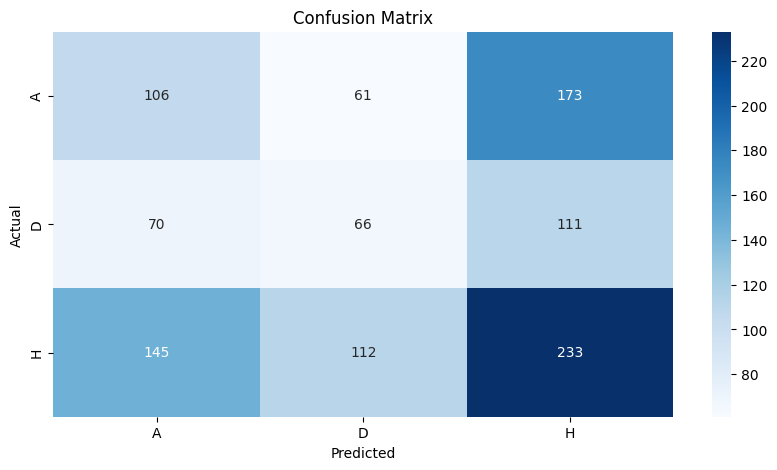

              precision    recall  f1-score   support

           A       0.33      0.31      0.32       340
           D       0.28      0.27      0.27       247
           H       0.45      0.48      0.46       490

    accuracy                           0.38      1077
   macro avg       0.35      0.35      0.35      1077
weighted avg       0.37      0.38      0.37      1077



In [86]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

### 4.2 Visualize Training Progress
Plot the training and validation accuracy/loss over epochs.

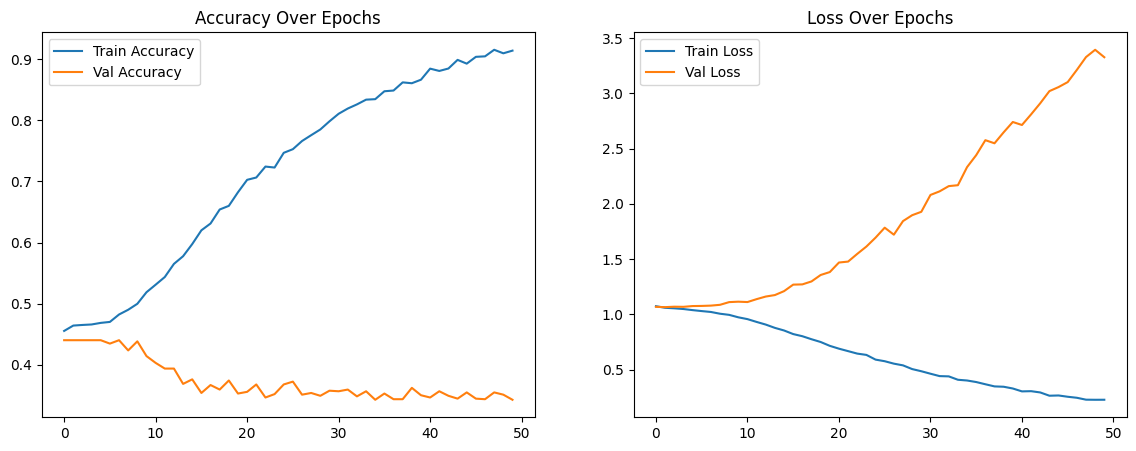

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0].legend()
axs[0].set_title('Accuracy Over Epochs')

# Plot loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].legend()
axs[1].set_title('Loss Over Epochs')

plt.show()

In [88]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        25,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,571 (322.55 KB)

 Trainable params: 27,523 (107.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,048 (215.04 KB)

## Step 5: Save baseline model

In [89]:
# save the model
path_to_save_model = os.path.join('..','models','baseline_lstm_model.keras')

model.save(path_to_save_model)

# how many MB the model is
os.path.getsize(path_to_save_model) / (1024 * 1024)  # in MB

0.34681034088134766

In [90]:
data[data['Season'] == 2024]['HomeTeam'].unique()

array(['Man United', 'Ipswich', 'Arsenal', 'Everton', 'Newcastle',
       "Nott'm Forest", 'West Ham', 'Brentford', 'Chelsea', 'Leicester',
       'Brighton', 'Crystal Palace', 'Fulham', 'Man City', 'Southampton',
       'Tottenham', 'Aston Villa', 'Bournemouth', 'Wolves', 'Liverpool'],
      dtype=object)

In [103]:
# testing model with a match between two teams
team1 = "Aston Villa"
team2 = 'Chelsea'

# time window
time_window = 5


# Get the last x matches for each team
team1_data = data[data['HomeTeam'] == team1].tail(time_window)
team2_data = data[data['AwayTeam'] == team2].tail(time_window)

# Concatenate the sequences
new_point = np.concatenate([team1_data[feature_cols].values, team2_data[feature_cols].values], axis=1)

# Scale the new point
new_point_scaled = scaler.transform(new_point)

# Reshape the new point
new_point_reshaped = new_point_scaled.reshape(1, time_window, -1)

# Make a prediction
prediction = model.predict(new_point_reshaped)

# Get the predicted class
predicted_class = le.inverse_transform(np.argmax(prediction, axis=1))[0]
print(f"The predicted winner between {team1} and {team2} is: {predicted_class}")

# Get the predicted probabilities
predicted_probabilities = dict(zip(le.classes_, prediction[0]))
print("Predicted Probabilities:")

for k, v in predicted_probabilities.items():
    print(f"{k}: {v:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
The predicted winner between Aston Villa and Chelsea is: H
Predicted Probabilities:
A: 0.00
D: 0.00
H: 1.00


In [98]:
le.inverse_transform(np.argmax(prediction, axis=1))

array(['H'], dtype=object)

In [100]:
team1_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
7301,2024-10-26,Aston Villa,Bournemouth,1.0,1.0,D,0.0,0.0,D,A Madley,18.0,11.0,8.0,3.0,12.0,14.0,9.0,7.0,7.0,6.0,0.0,0.0,1.85,3.90,3.80,2024
7332,2024-11-23,Aston Villa,Crystal Palace,2.0,2.0,D,1.0,2.0,A,T Robinson,17.0,13.0,5.0,6.0,10.0,11.0,10.0,1.0,3.0,2.0,0.0,0.0,1.62,4.00,5.50,2024
7357,2024-12-04,Aston Villa,Brentford,3.0,1.0,H,3.0,0.0,H,L Smith,20.0,9.0,10.0,1.0,11.0,15.0,10.0,5.0,2.0,2.0,0.0,0.0,1.80,3.75,4.33,2024
7360,2024-12-07,Aston Villa,Southampton,1.0,0.0,H,1.0,0.0,H,D Bond,18.0,4.0,5.0,0.0,18.0,15.0,14.0,1.0,1.0,3.0,0.0,0.0,1.36,5.50,7.00,2024
7379,2024-12-21,Aston Villa,Man City,2.0,1.0,H,1.0,0.0,H,P Bankes,11.0,12.0,6.0,6.0,14.0,7.0,5.0,4.0,3.0,3.0,0.0,0.0,3.25,3.70,2.10,2024


In [101]:
team2_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
7318,2024-11-03,Man United,Chelsea,1.0,1.0,D,0.0,0.0,D,R Jones,11.0,12.0,4.0,3.0,19.0,14.0,4.0,8.0,6.0,2.0,0.0,0.0,2.6,3.50,2.60,2024
7330,2024-11-23,Leicester,Chelsea,1.0,2.0,A,0.0,1.0,A,A Madley,4.0,16.0,1.0,7.0,15.0,12.0,2.0,9.0,4.0,3.0,0.0,0.0,6.5,4.75,1.44,2024
7355,2024-12-04,Southampton,Chelsea,1.0,5.0,A,1.0,3.0,A,T Harrington,6.0,26.0,4.0,13.0,7.0,14.0,5.0,7.0,1.0,0.0,1.0,0.0,8.5,5.25,1.33,2024
7367,2024-12-08,Tottenham,Chelsea,3.0,4.0,A,2.0,1.0,H,A Taylor,13.0,17.0,5.0,8.0,17.0,11.0,5.0,10.0,2.0,2.0,0.0,0.0,3.4,3.90,2.00,2024
7384,2024-12-22,Everton,Chelsea,0.0,0.0,D,0.0,0.0,D,C Kavanagh,5.0,12.0,4.0,5.0,20.0,12.0,2.0,5.0,4.0,1.0,0.0,0.0,5.0,4.20,1.62,2024
